In [2]:
import cv2
import pdfplumber
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')

def display_image(image, title="Image"):
    """Display image with a title using matplotlib."""
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# Image table detection and extraction function optimized for NxN tables
def extract_tables_from_image(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Convert to grayscale and apply adaptive threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Invert the image
    invert = cv2.bitwise_not(thresh)

    # Detect horizontal and vertical lines to find table structures
    horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))
    horizontal_lines = cv2.erode(invert, horizontal, iterations=1)
    vertical_lines = cv2.erode(invert, vertical, iterations=1)

    # Combine detected lines
    table_structure = cv2.addWeighted(horizontal_lines, 0.5, vertical_lines, 0.5, 0.0)

    # Find contours of table cells
    contours, _ = cv2.findContours(table_structure, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours to match table structure
    contours = sorted(contours, key=lambda c: (cv2.boundingRect(c)[1], cv2.boundingRect(c)[0]))

    data = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 20 and h > 20:  # Filter out very small or irrelevant contours
            cell_img = image[y:y+h, x:x+w]
            # Perform OCR on each cell
            result = ocr.ocr(cell_img, cls=True)
            cell_text = " ".join([line[1][0] for line in result[0]]) if result[0] else ""
            data.append([cell_text])

    # Convert the extracted text into a DataFrame
    df = pd.DataFrame(data)
    print("Extracted Table from Image OCR:")
    display(df.values)

    # Display the processed image with table detection
    display_image(table_structure, "Detected Table Structure")

# PDF table extraction function for N x N tables
def extract_tables_from_pdf(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        for i, page in enumerate(pdf.pages):
            # Extract table data from each page using pdfplumber
            tables = page.extract_table()
            if tables:
                df = pd.DataFrame(tables[1:], columns=tables[0])  # Use the first row as header
                print(f"Extracted Table Data from Page {i + 1}:")
                display(df)

# Main function to handle both PDFs and image files
def extract_tables(file_path):
    if file_path.lower().endswith(".pdf"):
        extract_tables_from_pdf(file_path)
    elif file_path.lower().endswith((".png", ".jpg", ".jpeg")):
        extract_tables_from_image(file_path)
    else:
        print("Unsupported file format. Please provide a PDF or image file.")

# Example usage



ModuleNotFoundError: No module named 'paddle'

In [ ]:
file_path = "table.pdf"  # Replace with the actual file path
extract_tables_from_pdf(file_path)

Extracted Table Data from Page 1:


,,None,None,,None,None,,None,None,,None,None,,Results,None,None,None,
0,None,None,None,None,None,None,None,None,None,,Ballots,,None,None,None,None,None,None
1,,Disability,,None,None,None,,Ballots,,None,None,None,None,None,None,None,None,None
2,None,None,None,,Participants,,None,None,None,None,Incomplete/,None,None,None,None,None,None,None
3,None,Category,None,None,None,None,None,Completed,None,None,None,None,,Accuracy,,,Time to,
4,None,None,None,None,None,None,None,None,None,None,Terminated,None,None,None,None,None,None,None
5,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,complete,None
6,None,None,None,,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,,None,None,None,None,None,,None,None,None,None,None,,None,None,None,None,None
8,None,None,None,None,None,None,None,None,None,,None,None,None,None,None,None,None,None
9,Blind,None,None,5,None,None,1,None,None,4,None,None,"34.5%, n=1",None,None,"1199 sec, n=1",None,None


[2024/10/14 20:17:21] ppocr DEBUG: dt_boxes num : 55, elapsed : 0.31384968757629395
[2024/10/14 20:17:22] ppocr DEBUG: cls num  : 55, elapsed : 0.5015726089477539
[2024/10/14 20:17:25] ppocr DEBUG: rec_res num  : 55, elapsed : 3.221637725830078
Extracted Table from Image OCR:


array([['ID NAME CLASS MARK GENDER 1 John Deo Four 75 female 2 Max Ruin Three 85 male Arnold Three 99 male 4 Krish Star Four 60 female 5 John Mike Four 60 female 6 Alex John Four 55 male 7 My John Rob Five 78 male 8 Asruid Five 85 male 9 Tes Qry Six 78 male 10 Big John Four 55 female']],
      dtype=object)

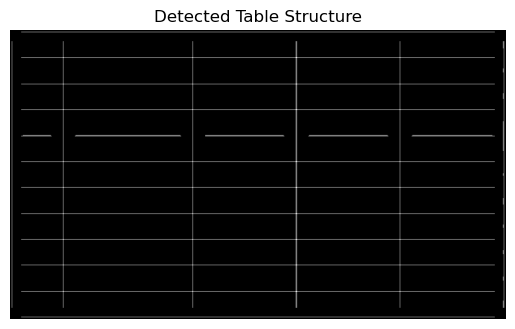

In [ ]:
file = "pdf-student-table.png"
extract_tables_from_image(file)